# Plot Gillespie simulation data

```md
From `./data/gillespie_sims/{test_name}`:
    - `average_curve_{num_samples}.csv
    - (`average_curve_{nsims}.csv` not needed here)
    - `continuous_observations_{num_sample}.csv`
```    

In [1]:
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
import pickle
import random
import os
import sys
sys.path.append('../../src/')
sys.path.append('../../scripts/')
from solve_kolmogorov import *
from simulate_gillespie import *
from estimate_total_rates import *

In [2]:
# --- setup ---
N = 1000
I0 = 50
nsims = 100
time_max = 10.0

In [ ]:
num_samples = 10
csv_base_dir = "../../data/gillespie_sims/"

test_names = ["complete", "random_ER", "regular", "scale_free"]

plot_titles = ["Complete", "Erdős-Rényi", "Regular", "Scale-Free"]

output_figure_dir = "../../figures/grid_figures/"
os.makedirs(output_figure_dir, exist_ok=True)

Processing: complete (subplot 1)
Loaded df_average_loaded from ../../data/gillespie_sims/complete/average_curve_10.csv
Processing: random_ER (subplot 2)
Loaded df_average_loaded from ../../data/gillespie_sims/random_ER/average_curve_10.csv
Processing: regular (subplot 3)
Loaded df_average_loaded from ../../data/gillespie_sims/regular/average_curve_10.csv
Processing: scale_free (subplot 4)
Loaded df_average_loaded from ../../data/gillespie_sims/scale_free/average_curve_10.csv
Combined figure saved to: ../../figures/results/gillespie_runs_all_classes.pdf


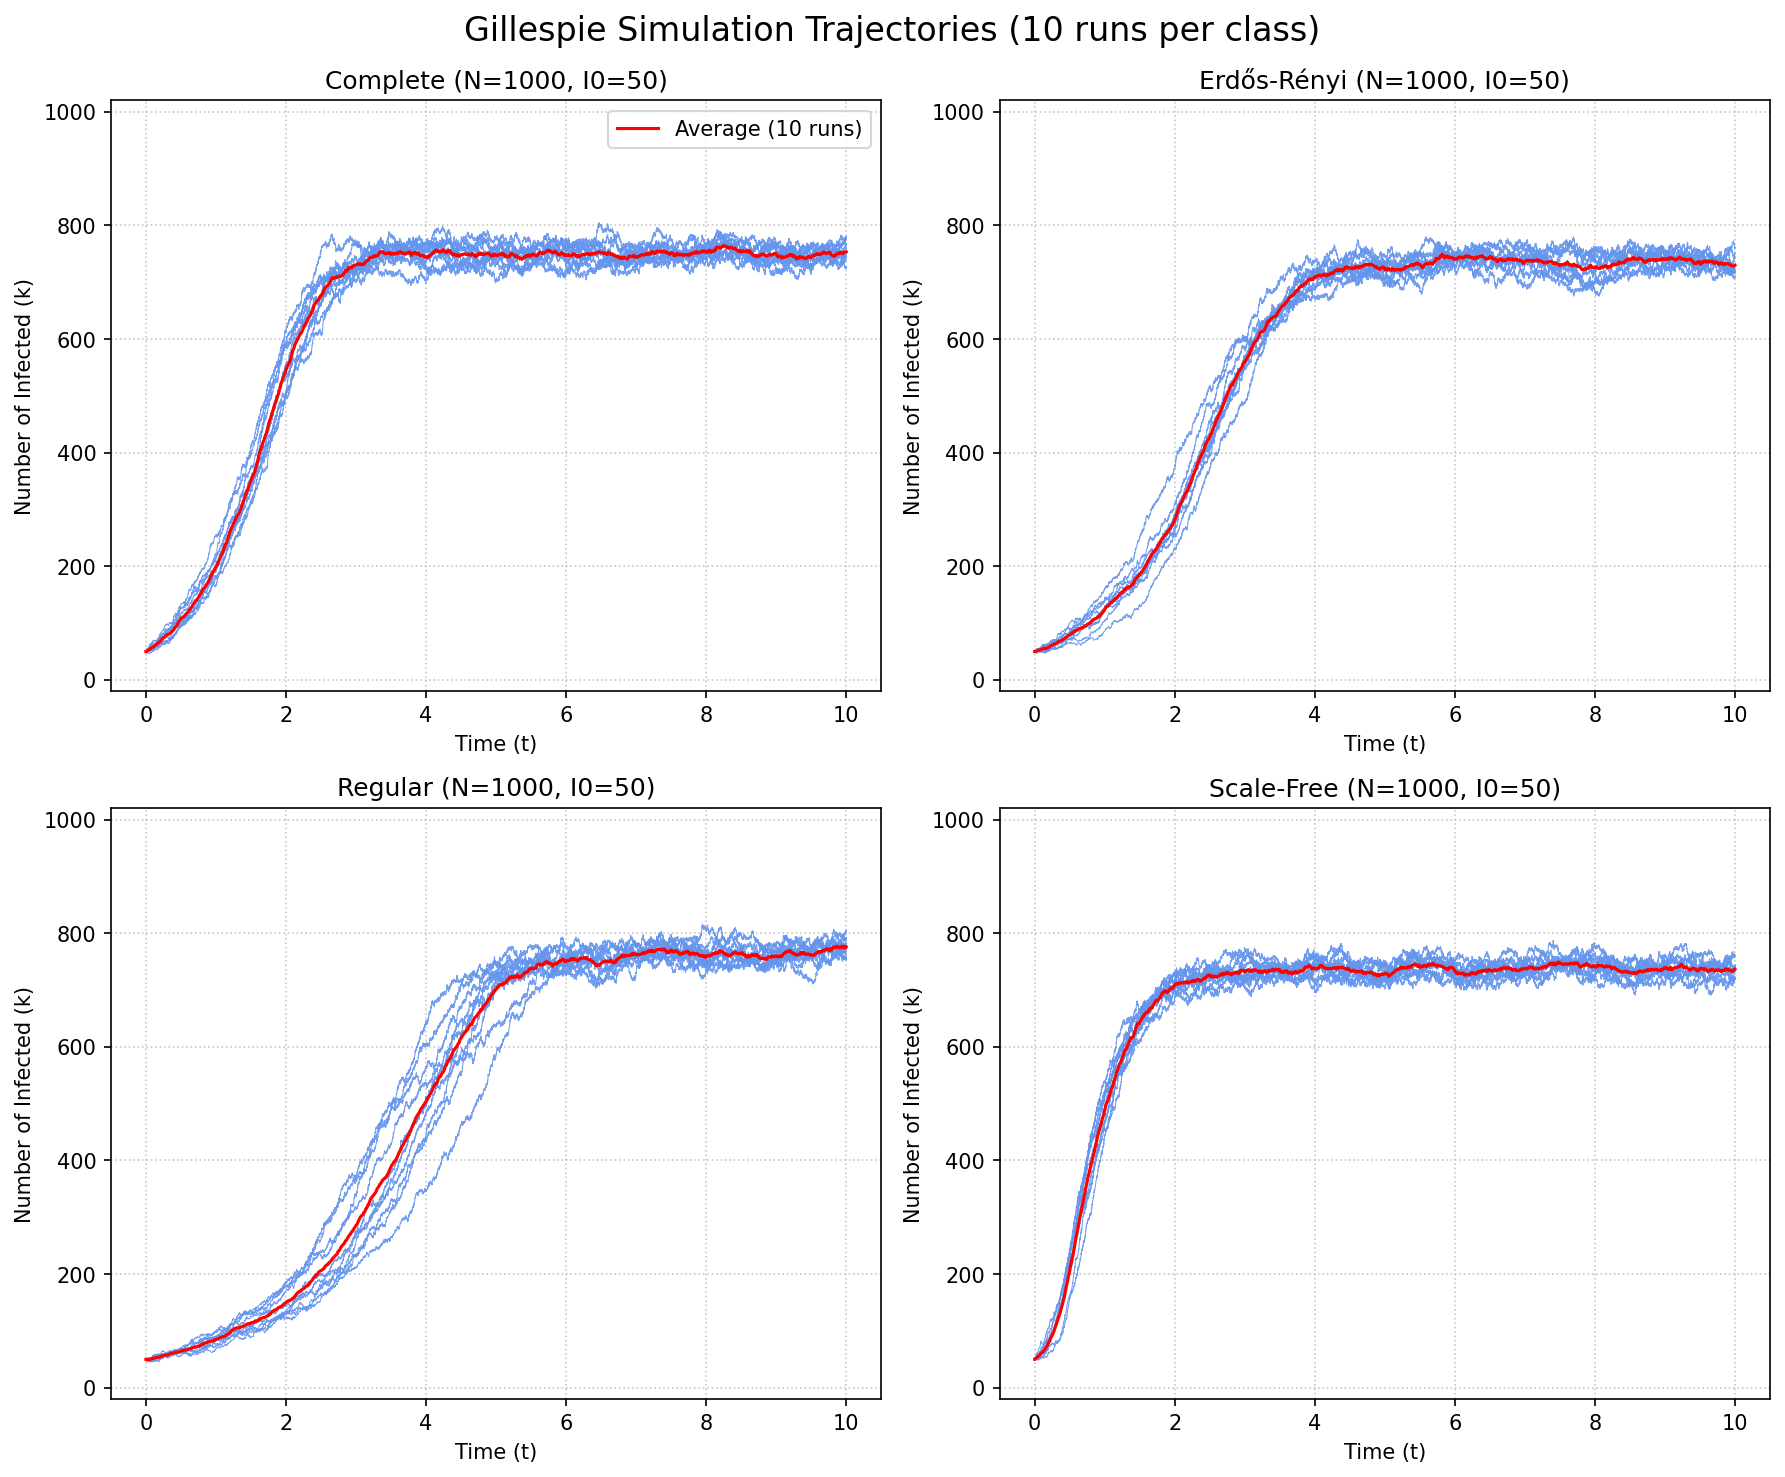

In [ ]:
# --- plot a 2x2 grid of subplots ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10), dpi=150)
axes = axes.flatten()

for i, test_name in enumerate(test_names):
    ax = axes[i]
    csv_dir = os.path.join(csv_base_dir, test_name)
    print(f"Processing: {test_name} (subplot {i + 1})")

    # load average curve
    avg_curve_file_name = os.path.join(csv_dir, f"average_curve_{num_samples}.csv")
    df_average_loaded = pd.read_csv(avg_curve_file_name)
    print(f"Loaded df_average_loaded from {avg_curve_file_name}")

    times_avg_loaded = df_average_loaded['time'].to_numpy()
    avg_curve_loaded = df_average_loaded['avg_infected_k'].to_numpy()

    # load sampled individual runs
    X_sims_loaded_from_csv = []
    for sample_idx in range(num_samples):
        sample_number = sample_idx + 1
        csv_filename = os.path.join(csv_dir, f"continuous_observations_{sample_number}.csv")
        df_loaded_run = pd.read_csv(csv_filename)

        run_times_loaded = df_loaded_run["t"].to_numpy()
        waiting_times_loaded = df_loaded_run["waiting_time"].to_numpy()
        infected_loaded = df_loaded_run["total_infected"].to_numpy(dtype=int)
        event_types_loaded = df_loaded_run["event_type"].to_numpy()
        pw_counts_loaded = df_loaded_run["total_pw_count"].to_numpy()
        ho_counts_loaded = df_loaded_run["total_ho_count"].to_numpy()
        
        # NaN / None handling
        event_types_processed = np.array([None if pd.isna(x) else x for x in event_types_loaded], dtype=object)
        def nan_to_none_if_object(arr):
            return np.array([None if pd.isna(x) else x for x in arr], dtype=object)
        waiting_times_processed = nan_to_none_if_object(waiting_times_loaded)
        pw_counts_processed = nan_to_none_if_object(pw_counts_loaded)
        ho_counts_processed = nan_to_none_if_object(ho_counts_loaded)

        # stack them into (6, num_events) structure
        X_t_reconstructed = np.array([
            run_times_loaded,
            waiting_times_processed,
            infected_loaded,
            event_types_processed,
            pw_counts_processed,
            ho_counts_processed
        ], dtype=object) # the outer array is also object type
        X_sims_loaded_from_csv.append(X_t_reconstructed)
    
    # plot sampled individual trajectories on the current subplot (ax) 
    for X_t in X_sims_loaded_from_csv:
        ax.plot(X_t[0], X_t[2], color="blue", alpha=0.9, linewidth=0.5, rasterized=True)

    # plot the average curve
    ax.plot(times_avg_loaded, avg_curve_loaded, color="red", linewidth=1.5, 
            label=f'Average ({num_samples} runs)')

    ax.set_xlabel("Time (t)")
    ax.set_ylabel("Number of Infected (k)")
    ax.grid(True, linestyle=':', alpha=0.7)
    ax.set_title(f"{plot_titles[i]} (N={N}, I0={I0})")
    ax.set_ylim(bottom=-N*0.02, top=N*1.02) # consistent y-limits
    if i == 0 : ax.legend() # add legend only to the first plot to avoid clutter

# adjust layout to prevent overlapping titles/labels
# rect=[left, bottom, right, top] to make space for suptitle
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle(f"Gillespie Simulation Trajectories ({num_samples} runs per class)", fontsize=16)

# --- save the combined 2x2 figure ---
output_figure_filename = os.path.join(output_figure_dir, "gillespie_runs_all_classes.pdf")
plt.savefig(output_figure_filename, format="pdf", bbox_inches="tight")
print(f"Combined figure saved to: {output_figure_filename}")

plt.show()
plt.close(fig) # free up memory